In [63]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 한글 깨짐 방지
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False
f_path = "C:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=f_path).get_name()
rc('font', family=font_name)

class PassMap:
    def __init__(self, pickle_file_path, image_path):
        self.pickle_file_path = pickle_file_path
        self.image_path = image_path
        self.data = None
        self.df_players_with_ball = None
        self.df_passmap_success = None
        self.df_passmap_fail = None
        self.df_passmap_bbox = None

    def load_data(self):
        try:
            with open(self.pickle_file_path, 'rb') as file:
                self.data = pickle.load(file)
        except FileNotFoundError:
            print(f"Error: {self.pickle_file_path} 파일을 찾을 수 없습니다.")
        except pickle.UnpicklingError:
            print("Error: 파일을 불러오는 중에 문제가 발생했습니다.")
    
    def players_withball_data(self):
        players_with_ball = []
        for frame in self.data['players']:
            for player_id, player_info in frame.items():
                if player_info.get('has_ball'):
                    players_with_ball.append({
                    'frame': self.data['players'].index(frame),
                    'player_initial': player_id,
                    'player_name': player_info['kr_name'],
                    'team': player_info['team'],
                    'coord_tr': player_info['coord_tr'],
                    })
        self.df_players_with_ball = pd.DataFrame(players_with_ball)
        # return self.df_players_with_ball
                                                 
    def player_average_coord(self):
        pass_player_name = self.df_players_with_ball['player_name'].unique().tolist()
        passmap_bbox = []
        for player_name in pass_player_name:
            coord_data = self.df_players_with_ball[self.df_players_with_ball['player_name'] == player_name]['coord_tr'].tolist()
            coord_average = [(sum(item)/len(item)) for item in zip(*coord_data)]
            passmap_bbox.append({
                'player_name': player_name,
                'team': self.df_players_with_ball[self.df_players_with_ball['player_name'] == player_name]['team'].tolist()[0],
                'coord_average': coord_average,
                'coord_average_x': coord_average[0],
                'coord_average_y': coord_average[1],
            })
        self.df_passmap_bbox = pd.DataFrame(passmap_bbox)
        # return self.df_passmap_bbox 

    def pass_success_rate(self):
        pass_success_count = self.df_passmap_success['passer_name'].value_counts()
        pass_success_count.name = 'pass_success_count'

        pass_fail_count = self.df_passmap_fail['passer_name'].value_counts()
        pass_fail_count.name = 'pass_fail_count'

        # 두 Series를 DataFrame으로 결합
        df_combined = pd.concat([pass_success_count, pass_fail_count], axis=1)

        # NaN 값을 0으로 대체
        df_pass_count = df_combined.fillna(0)

        df_pass_count['pass_success_rate'] = round(
            (df_pass_count['pass_success_count'] / 
             (df_pass_count['pass_success_count'] + df_pass_count['pass_fail_count'])) * 100, 2)

        df_pass_count_sorted = df_pass_count.sort_values(by='pass_success_rate', ascending=False).reset_index()
        
        return df_pass_count_sorted
    
    def create_passmap_data(self):
        passmap_success = []
        passmap_fail = []
        players_with_ball = self.df_players_with_ball.to_dict('records')

        for i in range(len(players_with_ball) - 1):
            if players_with_ball[i]['team'] == players_with_ball[i + 1]['team']:
                if players_with_ball[i]['player_name'] != players_with_ball[i + 1]['player_name']:
                    passmap_success.append({
                        'frame': players_with_ball[i]['frame'],
                        'passer_name': players_with_ball[i]['player_name'],
                        'passer_initial': players_with_ball[i]['player_initial'],
                        'passer_coord': players_with_ball[i]['coord_tr'],
                        'receiver_name': players_with_ball[i + 1]['player_name'],
                        'receiver_initial': players_with_ball[i + 1]['player_initial'],
                        'receiver_coord': players_with_ball[i + 1]['coord_tr'],
                        'team': players_with_ball[i]['team']
                    })
            else:
                passmap_fail.append({
                    'frame': players_with_ball[i]['frame'],
                    'passer_name': players_with_ball[i]['player_name'],
                    'passer_initial': players_with_ball[i]['player_initial'],
                    'passer_coord': players_with_ball[i]['coord_tr'],
                    'interceptor_name': players_with_ball[i + 1]['player_name'],
                    'interceptor_initial': players_with_ball[i + 1]['player_initial'],
                    'interceptor_coord': players_with_ball[i + 1]['coord_tr'],
                    'passer_team': players_with_ball[i]['team'],
                    'interceptor_team': players_with_ball[i + 1]['team']
                })
        
        for i in passmap_success:
            i['passer_x'] = self.df_passmap_bbox[self.df_passmap_bbox['player_name'] == i['passer_name']]['coord_average_x'].item()
            i['passer_y'] = self.df_passmap_bbox[self.df_passmap_bbox['player_name'] == i['passer_name']]['coord_average_y'].item()
            i['receiver_x'] = self.df_passmap_bbox[self.df_passmap_bbox['player_name'] == i['receiver_name']]['coord_average_x'].item()
            i['receiver_y'] = self.df_passmap_bbox[self.df_passmap_bbox['player_name'] == i['receiver_name']]['coord_average_y'].item()

        for i in passmap_fail:
            i['passer_x'] = self.df_passmap_bbox[self.df_passmap_bbox['player_name'] == i['passer_name']]['coord_average_x'].item()
            i['passer_y'] = self.df_passmap_bbox[self.df_passmap_bbox['player_name'] == i['passer_name']]['coord_average_y'].item()
            i['interceptor_x'] = self.df_passmap_bbox[self.df_passmap_bbox['player_name'] == i['interceptor_name']]['coord_average_x'].item()
            i['interceptor_y'] = self.df_passmap_bbox[self.df_passmap_bbox['player_name'] == i['interceptor_name']]['coord_average_y'].item()

        self.df_passmap_success = pd.DataFrame(passmap_success)
        self.df_passmap_fail = pd.DataFrame(passmap_fail)
        
        return self.df_passmap_success, self.df_passmap_fail  # 데이터프레임 반환
    
    def passmap_plot(self, df_passmap, team=None):
        if team is not None:
            df_passmap = df_passmap[df_passmap['team'] == team]
        
        img = mpimg.imread(self.image_path)
        
        plt.figure(figsize=(10, 6))
        plt.imshow(img)
        plt.axis('off')

        team_colors = {0: (0.15, 0.43, 0.86), 1: (0.9, 0.24, 0.15)}

        pass_counts = df_passmap.groupby('passer_name').size().to_dict()
        max_pass_counts = max([i for _, i in pass_counts.items()])

        for idx, row in df_passmap.iterrows():
            passer_x = row['passer_x']
            passer_y = row['passer_y']
            receiver_x = row['receiver_x']
            receiver_y = row['receiver_y']
            team_color = team_colors[row['team']]
            
            passer_count = pass_counts.get(row['passer_name'], 1)
            receiver_count = pass_counts.get(row['receiver_name'], 1)
            linewidth = (passer_count + receiver_count) * 0.5
            
            plt.plot([passer_x, receiver_x], [passer_y, receiver_y], color=team_color, alpha=0.25, linewidth=linewidth)
            
            passer_size = (passer_count / max_pass_counts) * 600
            receiver_size = (receiver_count / max_pass_counts) * 600
            plt.scatter(passer_x, passer_y, color='white', edgecolors='black', marker='o', s=passer_size, label=row['passer_name'], zorder=2)
            plt.scatter(receiver_x, receiver_y, color='white', edgecolors='black', marker='o', s=receiver_size, label=row['receiver_name'], zorder=2)

        avg_positions = df_passmap.groupby('passer_name')[['passer_x', 'passer_y']].mean()
        for idx, row in avg_positions.iterrows():
            avg_x = row['passer_x']
            avg_y = row['passer_y']
            plt.text(avg_x, avg_y - 35, idx, fontsize=10, fontweight='bold', ha='center', va='top', color='black', zorder=3)
        
        output_path = r"C:\Users\Playdata\Desktop\너구리\passmap.jpg"
        plt.savefig(output_path, dpi=300, bbox_inches='tight')

In [64]:
pickle_file_path = r"C:\Users\Playdata\Desktop\passmap\tracks_name+ba.pkl"
image_path = r"C:\Users\Playdata\Desktop\passmap\playball.png"

In [65]:
passmap = PassMap(pickle_file_path, image_path)
passmap.load_data()

In [66]:
passmap.players_withball_data()

In [67]:
passmap.player_average_coord()

In [68]:
df_success, df_fail  = passmap.create_passmap_data()

In [69]:
passmap.pass_success_rate()

,passer_name,pass_success_count,pass_fail_count,pass_success_rate
0,가윤성,5,1,83.33
1,김성욱,5,1,83.33
2,서한울,9,4,69.23
3,오지영,8,7,53.33
4,강동욱,5,7,41.67
5,김성일,5,10,33.33
6,손명준,1,5,16.67
7,신대근,1,10,9.09


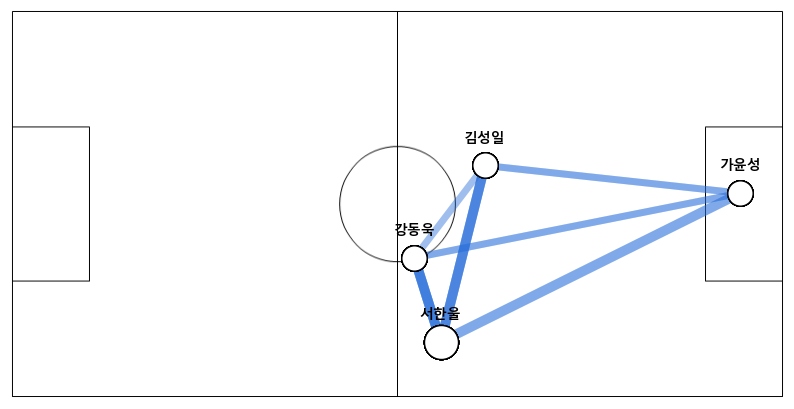

In [70]:
passmap.passmap_plot(df_success, 0) 

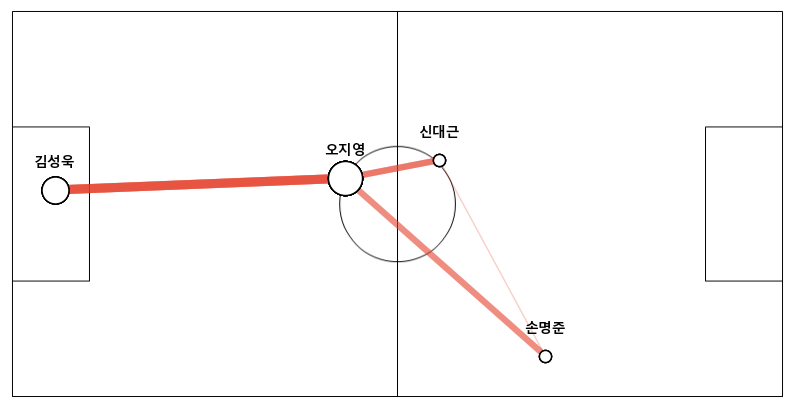

In [59]:
passmap.passmap_plot(df_success, 1) 

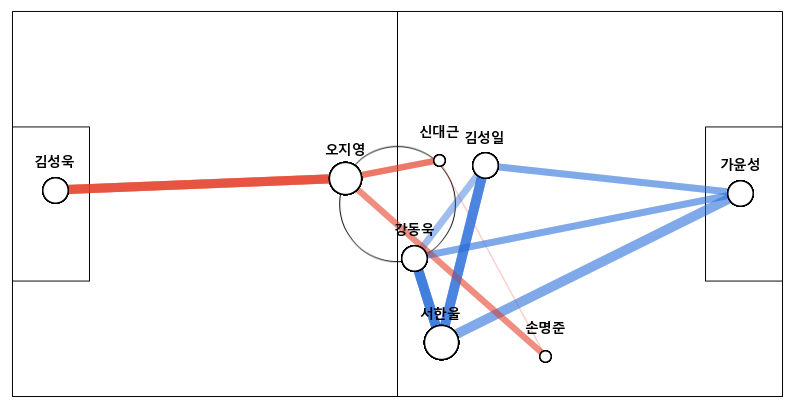

In [65]:
passmap.passmap_plot(df_success) 